In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from AutoValidator.model_tester import ModelTester
from utils.progress import ProgressBar
progress = ProgressBar()

In [4]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')
hurst_estimates.set_index('Unnamed: 0', inplace=True)

In [5]:
class ExponentialMovingAvgEstimator():
    
    def __init__(self, horizon, back_horizon=None):
        self.horizon = horizon
        
        if back_horizon is None:
            back_horizon = horizon
        self.back_horizon = back_horizon
        
    def fit(self, train, labels):
        self.starting_horizon = labels[-(self.back_horizon):]
        
    def predict(self, data):
        comb_data = np.hstack([self.starting_horizon, data])
        
        return np.repeat(pd.Series(comb_data[::-1]).ewm(self.back_horizon, adjust=False).mean().dropna(axis=0).values[-len(data):][::-1], self.horizon).reshape(len(data), self.horizon)
    
    def __repr__(self):
        return 'Exp Moving Avg Estimator: (h={:d})'.format(self.horizon)

In [6]:
t = np.arange(0, 100)

In [7]:
ema = ExponentialMovingAvgEstimator(5, 10)

In [8]:
ema.fit(t[:80], t[:80])

In [9]:
t[80:]

array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
       97, 98, 99])

In [10]:
a = ema.predict(t[80:])

In [11]:
a

array([[79.36960591, 79.36960591, 79.36960591, 79.36960591, 79.36960591],
       [80.30656651, 80.30656651, 80.30656651, 80.30656651, 80.30656651],
       [81.23722316, 81.23722316, 81.23722316, 81.23722316, 81.23722316],
       [82.16094547, 82.16094547, 82.16094547, 82.16094547, 82.16094547],
       [83.07704002, 83.07704002, 83.07704002, 83.07704002, 83.07704002],
       [83.98474402, 83.98474402, 83.98474402, 83.98474402, 83.98474402],
       [84.88321842, 84.88321842, 84.88321842, 84.88321842, 84.88321842],
       [85.77154026, 85.77154026, 85.77154026, 85.77154026, 85.77154026],
       [86.64869429, 86.64869429, 86.64869429, 86.64869429, 86.64869429],
       [87.51356372, 87.51356372, 87.51356372, 87.51356372, 87.51356372],
       [88.36492009, 88.36492009, 88.36492009, 88.36492009, 88.36492009],
       [89.2014121 , 89.2014121 , 89.2014121 , 89.2014121 , 89.2014121 ],
       [90.02155331, 90.02155331, 90.02155331, 90.02155331, 90.02155331],
       [90.82370864, 90.82370864, 90.8

## 1 minute horizon

In [12]:
horizon = 1
ema = ExponentialMovingAvgEstimator(horizon, 10)

In [13]:
one_min_tester = ModelTester(data, horizon, 0.20)

one_min_tester.add_model(ema)

In [14]:
# results = five_min_tester.test_models()
one_min_tester.results[repr(ema)] = {}

progress.set_length(len(data.columns))
for column in data.columns:
    
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test)]
    ema.fit(train, train)
    pred = ema.predict(test)
    
    one_min_tester.results[repr(ema)][column] = pred
    progress.progress()

Progress: [####################] 100.0%


In [15]:
one_min_errors = one_min_tester.evaluate_model([repr(ema)])

Progress: [####################] 100.0%


In [16]:
one_min_errors.head()

,Exp Moving Avg Estimator: (h=1)_RMSE,Exp Moving Avg Estimator: (h=1)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,143.331202,0.165225,143.331202,0.0,0.165225,0.0
window_1_1,179.377699,0.190856,179.377699,0.0,0.190856,0.0
window_1_2,206.837292,0.251366,206.837292,0.0,0.251366,0.0
window_1_3,216.934415,0.226413,216.934415,0.0,0.226413,0.0
window_1_4,242.153801,0.341419,242.153801,0.0,0.341419,0.0


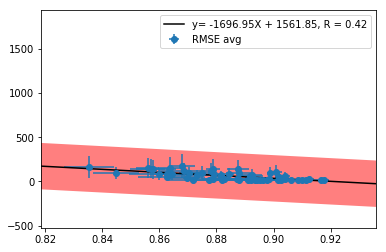

In [17]:
one_min_tester.compare_hurst(hurst_estimates, errors=one_min_errors)

In [18]:
one_min_errors.to_csv('results/one_minute_exponential_moving_average_results.csv')

## 5 minute horizon

In [19]:
horizon = 5

ema = ExponentialMovingAvgEstimator(horizon, 10)

In [20]:
five_min_tester = ModelTester(data, horizon, 0.20)

five_min_tester.add_model(ema)

In [21]:
# results = five_min_tester.test_models()
five_min_tester.results[repr(ema)] = {}

five_min_tester.progressBar.set_length(len(data.columns))
for column in data.columns:
    five_min_tester.progressBar.progress()
    
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    ema.fit(train, train)
    pred = ema.predict(test)
    
    five_min_tester.results[repr(ema)][column] = pred

Progress: [####################] 100.0%


In [22]:
five_min_errors = five_min_tester.evaluate_model([repr(ema)])

Progress: [####################] 100.0%


In [23]:
five_min_errors.head()

,Exp Moving Avg Estimator: (h=5)_RMSE,Exp Moving Avg Estimator: (h=5)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,154.109606,0.183142,154.109606,0.0,0.183142,0.0
window_1_1,193.496155,0.210062,193.496155,0.0,0.210062,0.0
window_1_2,221.279257,0.273352,221.279257,0.0,0.273352,0.0
window_1_3,232.135984,0.246227,232.135984,0.0,0.246227,0.0
window_1_4,259.110385,0.369775,259.110385,0.0,0.369775,0.0


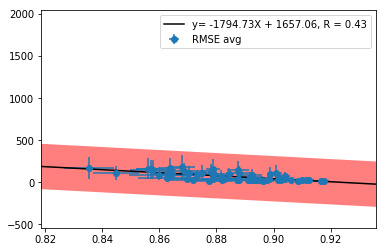

In [25]:
five_min_tester.compare_hurst(hurst_estimates, errors=five_min_errors)

In [26]:
five_min_errors.to_csv('results/five_minute_exponential_moving_average_results.csv')

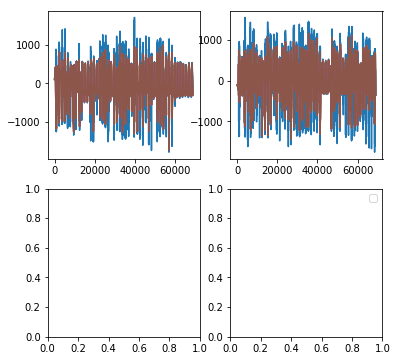

In [27]:
five_min_tester.visualise_result(repr(ema), [1, 2])

## 60 minute horizon

In [28]:
horizon = 60
ema = ExponentialMovingAvgEstimator(horizon, 60)

In [29]:
sixty_min_tester = ModelTester(data, horizon, 0.20)

sixty_min_tester.add_model(ema)

In [30]:
# results = five_min_tester.test_models()
sixty_min_tester.results[repr(ema)] = {}

sixty_min_tester.progressBar.set_length(len(data.columns))
for column in data.columns:
    sixty_min_tester.progressBar.progress()
    
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test)]
    ema.fit(train, train)
    pred = ema.predict(test)
    
    sixty_min_tester.results[repr(ema)][column] = pred

Progress: [####################] 100.0%


In [31]:
sixty_min_errors = sixty_min_tester.evaluate_model([repr(ema)])

Progress: [####################] 100.0%


In [32]:
sixty_min_errors.head()

,Exp Moving Avg Estimator: (h=60)_RMSE,Exp Moving Avg Estimator: (h=60)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,241.544293,0.446867,241.544293,0.0,0.446867,0.0
window_1_1,281.938636,0.459337,281.938636,0.0,0.459337,0.0
window_1_2,322.316815,0.525479,322.316815,0.0,0.525479,0.0
window_1_3,339.320024,0.493690,339.320024,0.0,0.493690,0.0
window_1_4,352.628650,0.653304,352.628650,0.0,0.653304,0.0


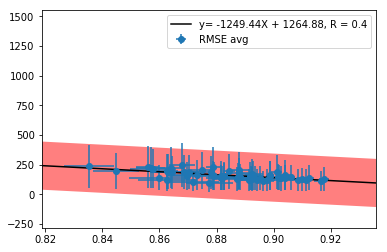

In [33]:
sixty_min_tester.compare_hurst(hurst_estimates, errors=sixty_min_errors)

In [34]:
sixty_min_errors.to_csv('results/sixty_minute_exponential_moving_average_results.csv')

In [35]:
%matplotlib notebook
plt.plot(preds[0])
plt.plot(tests[0])

pred_at = np.arange(0, len(pred), 60)
plt.scatter(pred_at, preds[0][pred_at])

NameError: name 'preds' is not defined